In [18]:
# 1.1)
import os
import pickle
import datetime
from collections import defaultdict

In [19]:
# 1.2)
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
#import sklearn as skl
import pandas as pd
#import dill
import json

In [20]:
# 1.3
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
#from torchviz import make_dot

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.version.cuda)

cuda
11.8


In [22]:
transform = transforms.Compose([
                                transforms.ToTensor()
                                #,transforms.Normalize((0.5,), (0.5,))
                                #,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

# Download and load the training data
train_set = datasets.FashionMNIST('MNIST_data/', download = True, train = True,  transform = transform)
valid_set = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)


print(len(train_set))  # 60000
print(len(valid_set))        # 10000''''''

60000
10000


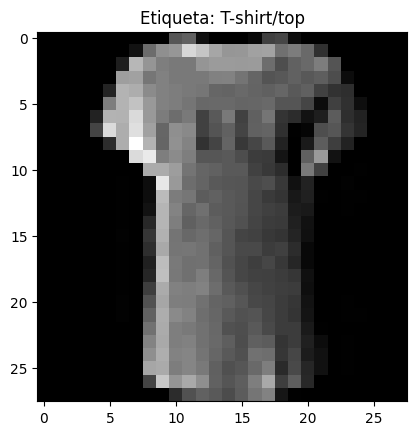

Forma del tensor de la imagen: torch.Size([1, 28, 28])


In [23]:
i = 600
img, label = train_set[i]

#2.3
label_dict = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

# Como tiene forma [1, 28, 28], quitamos la dimensión del canal

plt.imshow(img.squeeze(), cmap='gray')
plt.title(f"Etiqueta: {label_dict[label]}")
plt.show()
print(f"Forma del tensor de la imagen: {img.shape}")

In [24]:
class Encoder1(nn.Module):
    def __init__(self, n, p=0.2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),  # -> 14x14
            nn.Dropout(p),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),  # -> 7x7
            nn.Dropout(p),
            nn.Flatten(), # ->32*7*7 = 1568 
            nn.Linear(32*7*7, n), #-> n
        )

    def forward(self, x):
        return self.encoder(x)

encoder1 = Encoder1(n=128, p=0.2)  
checkpoint = torch.load("./TP_FINAL/Guia12/CASO1/encoder_caso1.pth")
encoder1.encoder.load_state_dict(checkpoint['encoder_state_dict'])
encoder1.eval()

Encoder1(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=1568, out_features=128, bias=True)
  )
)

In [25]:
class Encoder2(nn.Module):
    def __init__(self, n, p=0.2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),  # 28x28x1 -> 28x28x32
            nn.ReLU(),
            nn.MaxPool2d(2,2),               # 28x28x32 -> 14x14x32
            nn.Dropout(p),
            nn.Conv2d(32, 64, 3, padding=1), # 14x14x32 -> 14x114x64
            nn.ReLU(),
            nn.MaxPool2d(2,2),               # 14x14x64 -> 7x7x64
        )

    def forward(self, x):
        return self.encoder(x)

encoder2 = Encoder2(n=128, p=0.2)  
checkpoint = torch.load("./TP_FINAL/Guia12/CASO2/encoder_caso2.pth")
encoder2.encoder.load_state_dict(checkpoint['encoder_state_dict'])
encoder2.eval()

Encoder2(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)

In [26]:
class Classifier(nn.Module):
    def __init__(self,encoder,n1,n2,p=0.2):
        super(Classifier,self).__init__()
        #capa0
        #self.flatten = nn.Flatten() 
        self.encoder = encoder
        #capa 1
        
        self.fc1 = nn.Linear(128,n1)  
        self.flatten = nn.Flatten()

        #self.fc1 = nn.Linear(64*7*7,n1)
        self.relu = nn.ReLU() #modulo relu1
        self.dropout = nn.Dropout(p) #modulo dropout1

        #capa2
        self.fc2 = nn.Linear(n1,n2)      #capa 2
        #self.relu2 = nn.ReLU()           #modulo relu2 (se reutilizan las del 1 asi q las comento)
        #self.dropout2 = nn.Dropout(p)    #modulo dropout2

        #capa3
        self.fc3 = nn.Linear(n2,10)     #capa 3
    
    def forward(self,x):
        #capa0
        x = self.encoder(x)
        #capa1
        #x = self.flatten(x)
        x = self.fc1(x)             
        x = self.relu(x)            #modulo relu1
        x = self.dropout(x)         #modulo dropout1
        #capa2
        x = self.fc2(x)             
        x = self.relu(x)            #modulo relu2
        x = self.dropout(x)         #modulo dropout2
        #capa3
        x = self.fc3(x)             
        return x

#classifier = Classifier(encoder=encoder1.encoder, n1=64, n2=32, p=0.2)

In [27]:
# 5.1)
def train_loop(dataloader,model,loss_fn,optimizer):
    model.train()
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0
    for batch, (X,y) in enumerate(dataloader): 
        #enumerate devuelve una lista de tuplas (indice, valor), entonces al hacer
        # for batch, (X,y) desestructura la tupla en indice(batch) y valor(X(imagenes), y(etiquetas))

        # Copiamos las salidas y entradas al dispositivo de trabajo
        X, y = X.to(device,non_blocking=True), y.to(device,non_blocking=True)

        # Forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        batch_size = len(X)
        # calculamos la perdida promedio del batch y lo agregamos a una suma correspondiente
        sum_loss += loss.item() * batch_size # loss = suma de perdidas en el batch / batch_size => loss.item() * batch_size = suma de perdidas en el batch

        # calculamos la cantidad de predicciones correctas en el batch y lo agregamos a una suma correspondiente
        sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        # actualizamos la cantidad de muestras procesadas
        sum_samples += batch_size

        if batch % (num_batches / 10) == 0: # evaluamos en el 10% de los batches, para no saturar
            avrg_loss = sum_loss / sum_samples
            precision = sum_correct / sum_samples
            print(f"  Batch {batch:>5d}/{num_batches:>5d} - avrg_Loss: {avrg_loss:>7f}  processed_samples: {100*sum_samples/num_samples:>5f}%") #5d ?
        
    assert num_samples == sum_samples, "Error en el conteo de muestras procesadas"
    avrg_loss = sum_loss / sum_samples
    precision = sum_correct / sum_samples

    return avrg_loss, precision

In [28]:
def valid_loop(dataloader,model,loss_fn):
    model.eval()
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0
    with torch.no_grad(): # es un context manager que desactiva el cálculo del gradiente momentáneamente, 
        #para ahorrar memoria y mejorar el rendimiento durante la evaluación del modelo.

        for X,y in dataloader: #iteramos sobre los batches del dataloader, esto es posible ya que si bien dataloader no es una lista,
            # implementa el protocolo iterable de python, por lo que se puede usar en un for, y en cada iteracion genera un batch nuevo

            # Copiamos las salidas y entradas al dispositivo de trabajo
            X, y = X.to(device,non_blocking=True), y.to(device,non_blocking=True)
            batch_size = len(X)
            sum_samples += batch_size

            pred = model(X)
            loss = loss_fn(pred, y)

            sum_loss += loss.item() * batch_size
            sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    
    assert num_samples == sum_samples, "Error en el conteo de muestras procesadas"
    avrg_loss = sum_loss / sum_samples
    precision = sum_correct / sum_samples
    # print(f"@eval_loop_avg_loss={avrg_loss:>8f}  precision={100*precision:0.1f}%")

    return avrg_loss, precision

In [29]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True,num_workers=8, pin_memory=True,persistent_workers=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = batch_size, shuffle = True,num_workers=8, pin_memory=True,persistent_workers=True)

In [30]:
#Creamos una instancia de una funcion de perdida, en este caso Cross Entropy Loss
loss_fn = nn.CrossEntropyLoss()

In [31]:
n1 = 256
n2 = 64
p = 0.3
encoder = encoder1.encoder
model = Classifier(encoder, n1, n2, p)


for param in model.encoder.parameters():
    param.requires_grad = True


#5.5)
#definimos el optimizador, en este caso SGD
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#pasamos el modelo al dispositivo
model = model.to(device)
print(torch.cuda.is_available())

True


In [ ]:
import time
t_i = time.time()

num_epochs = 100
list_train_avg_loss_incorrecta = []
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precisiom_incorrecta = []
list_train_precision = []
list_valid_precision = []

# Variables para la detección de Overfitting (Early Stopping)
best_valid_loss = float('inf') # La mejor (mínima) pérdida de validación observada hasta ahora
epochs_no_improve = 0            # Contador de épocas sin mejora en la pérdida de validación
patience = 5                     # Número de épocas a esperar después de la última mejora
overfitting_detected = False     # Flag para indicar si se detectó overfitting
overfitting_epoch = -1           # Época en la que se detectó el overfitting
overfitting_train_loss = -1.0
overfitting_valid_loss = -1.0

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}:\n-------------------------------")
    train_avg_loss_incorrecta, train_precision_incorrecta = train_loop(train_loader, model, loss_fn, optimizer)
    train_avg_loss, train_precision = valid_loop(train_loader, model, loss_fn)
    valid_avg_loss, valid_precision = valid_loop(valid_loader, model, loss_fn)

    list_train_avg_loss_incorrecta.append(train_avg_loss_incorrecta)
    list_train_precisiom_incorrecta.append(train_precision_incorrecta)

    list_train_avg_loss.append(train_avg_loss)
    list_valid_avg_loss.append(valid_avg_loss)

    list_train_precision.append(train_precision)
    list_valid_precision.append(valid_precision)

       # --- Lógica de Detección de Overfitting ---
    if not overfitting_detected:
        if valid_avg_loss < best_valid_loss:
            best_valid_loss = valid_avg_loss
        elif patience<0 and not overfitting_detected:
            overfitting_detected = True
            overfitting_epoch = epoch + 1 # +1 porque epoch es base 0
            overfitting_train_loss = train_avg_loss
            overfitting_valid_loss = valid_avg_loss
            print(f"\n***POSIBLE OVERFITTING DETECTADO***")
            print(f"La pérdida de validación no mejoró o aumentó en la **Época {overfitting_epoch}**.")
            print(f"Loss de Entrenamiento (Evaluación 10k): {overfitting_train_loss:.4f}")
            print(f"Loss de Validación (Mejor anterior): {best_valid_loss:.4f}")
            print(f"Loss de Validación (Actual): {overfitting_valid_loss:.4f}\n")
        else:
            patience=patience-1
    # --------------------------------------------


    if (epoch + 1) % 10 == 0:
        print(f"\n----------------------------------------------------------------------")
        print(f"Epoch {epoch+1}/{num_epochs}: train_avg_loss={train_avg_loss:.4f}, valid_avg_loss={valid_avg_loss:.4f}")
        print(f"\ntrain_precision={100*train_precision:0.1f}%, valid_precision={100*valid_precision:0.1f}%")
        print("\n-----------------------------------------------------------------------")


print(f"Tiempo de ejecución: {(time.time()-t_i)/60:.2f} minutos")
print("Training complete.")

In [ ]:
# probando la red entrenada con un ejemplito
dataiter = iter(valid_loader)
images, labels = next(dataiter)
numero_img = 16
img = images[numero_img]  # Agregar dimensión de batch
label = labels[numero_img].item()
# Pasar la imagen por el modelo
with torch.no_grad():
    img = img.to(device)
    output = model(img.unsqueeze(0))  # Agregar dimensión de batch
    predicted_label = output.argmax(1).item()

#imagen:
plt.imshow(img.cpu().squeeze(), cmap='gray')
plt.title(f"Etiqueta real: {label_dict[label]}\nEtiqueta predicha: {label_dict[predicted_label]}")
plt.show()

img.shape

In [33]:
from datetime import datetime

'''timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"checkpoint_{timestamp}.pth"

checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': list_train_avg_loss,
    'valid_loss': list_valid_avg_loss,
    'train_precision': list_train_precision,
    'valid_precision': list_valid_precision
}

torch.save(checkpoint, filename)
print("Guardado como:", filename)
'''

# Cargar el checkpoint desde archivo
checkpoint = torch.load("./TP_FINAL/GuiaFinal/bottleneck/EXP2/exp2.pth")  # reemplazá por tu nombre real del archivo

# Restaurar el estado del modelo
model.load_state_dict(checkpoint['model_state_dict'])

# Restaurar el estado del optimizador
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Restaurar el epoch (si lo necesitas para continuar)
#start_epoch = checkpoint['epoch'] + 1  # comenzar en el siguiente epoch

# Restaurar métricas si las querés seguir usando
list_train_avg_loss = checkpoint['train_loss']
list_valid_avg_loss = checkpoint['valid_loss']
list_train_precision = checkpoint['train_precision']
list_valid_precision = checkpoint['valid_precision']

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # 1 fila, 2 columnas

# --- Gráfico de Loss ---
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Average Loss")
axs[0].plot(range(1,len(list_train_avg_loss_incorrecta)+1), list_train_avg_loss_incorrecta, label="Train Loss Incorrecta", linestyle='-', c='red')
axs[0].plot(range(1,len(list_train_avg_loss)+1), list_train_avg_loss, label="Train Loss", linestyle='-.', c='green')
axs[0].plot(range(1,len(list_valid_avg_loss)+1), list_valid_avg_loss, label="Valid Loss", linestyle='--', c='blue')
axs[0].legend()
axs[0].set_title("Pérdida (Loss)")

# --- Gráfico de Precisión ---
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Precision")
axs[1].plot(range(1,len(list_train_precisiom_incorrecta)+1),  list_train_precisiom_incorrecta, label="Train Precision Incorrecta", linestyle='-', c='red')
axs[1].plot(range(1,len(list_train_precision)+1),  list_train_precision, label="Train Precision", linestyle='-', c='green')
axs[1].plot(range(1,len(list_valid_precision)+1), list_valid_precision, label="Valid Precision", linestyle='--', c='blue')
axs[1].legend()
axs[1].set_title("Precisión")

plt.tight_layout()  # Ajuste automático para que no se pisen los elementos
plt.show()


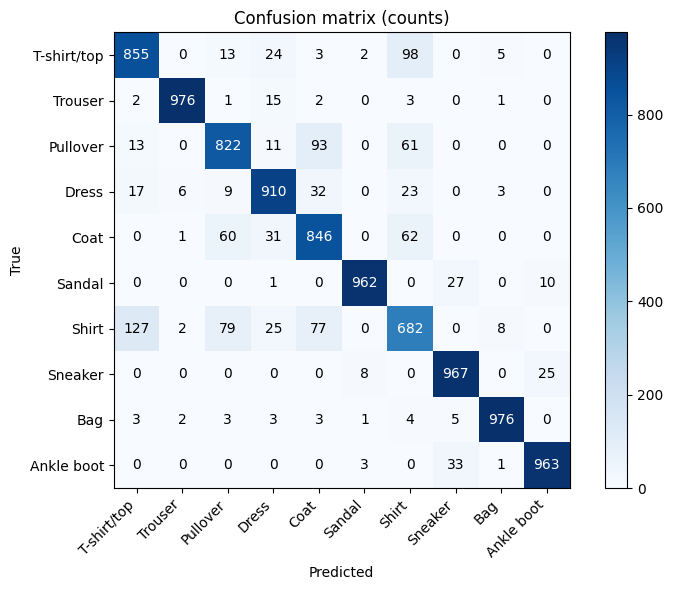

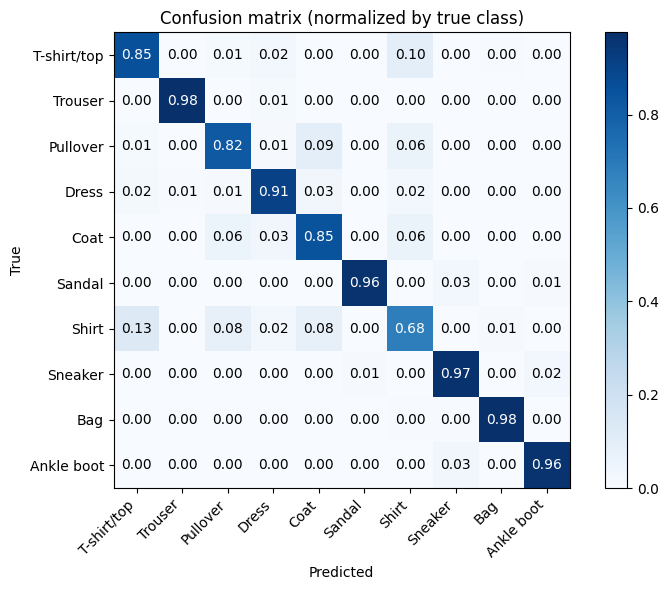

In [34]:
from sklearn.metrics import confusion_matrix

model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X, y in valid_loader:
        X, y = X.to(device), y.to(device)
        out = model(X)
        preds = out.argmax(dim=1)
        y_true.append(y.cpu().numpy())
        y_pred.append(preds.cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# matriz de confusión (conteos)
cm = confusion_matrix(y_true, y_pred, labels=list(range(10)))

# plot de la matriz de confusión (conteos)
fig, ax = plt.subplots(figsize=(8,6))
cax = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar(cax, ax=ax)
classes = [label_dict[i] for i in range(10)]
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.set_yticklabels(classes)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion matrix (counts)')
# Anotar celdas
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()

# matriz de confusión normalizada por fila (recall por clase)
cm_norm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-12)

fig, ax = plt.subplots(figsize=(8,6))
cax = ax.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar(cax, ax=ax)
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.set_yticklabels(classes)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion matrix (normalized by true class)')
# Anotar celdas con porcentaje
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, f"{cm_norm[i, j]:.2f}",
                ha="center", va="center",
                color="white" if cm_norm[i, j] > 0.5 else "black")
plt.tight_layout()
plt.show()
